# Motif Discovery

In [2]:
from matrixprofile import *
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
pattern = np.loadtxt('pattern.txt')

In [4]:
m=100
mp = matrixProfile.stomp(pattern,m)

In [5]:
def plot_motifs(mtfs, labels, ax):

    colori = 0
    colors = 'rgbcm'
    for ms,l in zip(mtfs,labels):
        c =colors[colori % len(colors)]
        starts = list(ms)
        ends = [min(s + m,len(pattern)-1) for s in starts]
        ax.plot(starts, pattern[starts],  c +'o',  label=l)
        ax.plot(ends, pattern[ends],  c +'o', markerfacecolor='none')
        for nn in ms:
            ax.plot(range(nn,nn+m),pattern[nn:nn+m], c , linewidth=2)
        colori += 1

    ax.plot(pattern, 'k', linewidth=1, label="data")
    ax.legend()

In [6]:
mtfs ,motif_d  = motifs.motifs(pattern, mp, max_motifs=10)

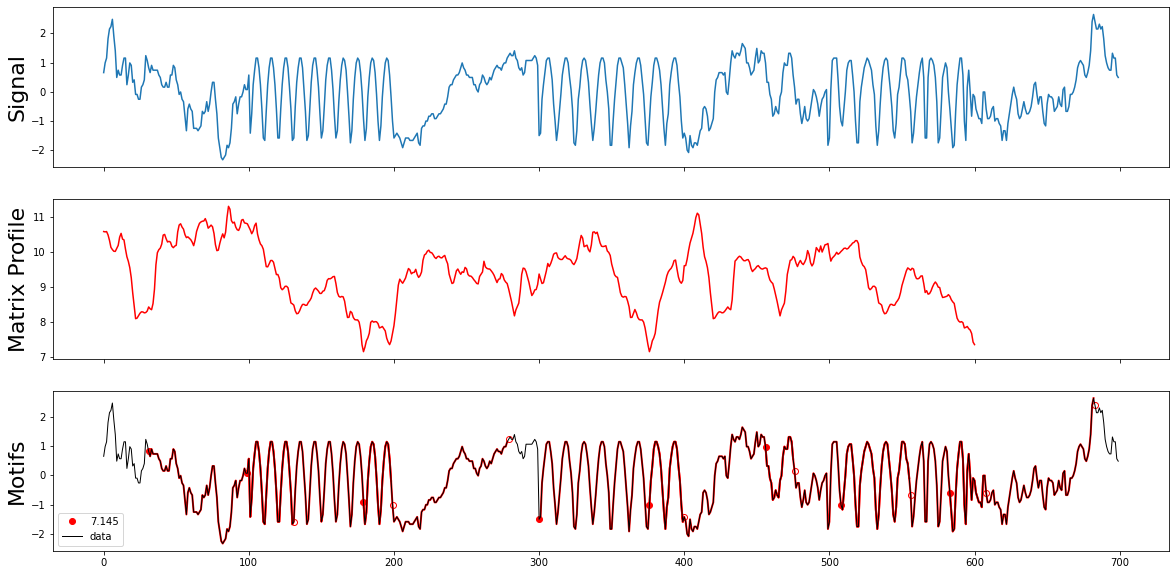

In [7]:
#Append np.nan to Matrix profile to enable plotting against raw data
mp_adj = np.append(mp[0],np.zeros(m-1)+np.nan)

#Plot the signal data
fig, (ax1, ax2, ax3) = plt.subplots(3,1,sharex=True,figsize=(20,10))
ax1.plot(np.arange(len(pattern)),pattern, label="Synthetic Data")
ax1.set_ylabel('Signal', size=22)

#Plot the Matrix Profile
ax2.plot(np.arange(len(mp_adj)),mp_adj, label="Matrix Profile", color='red')
ax2.set_ylabel('Matrix Profile', size=22)

#Plot the Motifs
plot_motifs(mtfs, [f"{md:.3f}" for md in motif_d], ax3)
ax3.set_ylabel('Motifs', size=22)
#plt.xlim((0,100))
plt.savefig('motifsN.png', dpi=300, bbox_inches='tight')
plt.show()


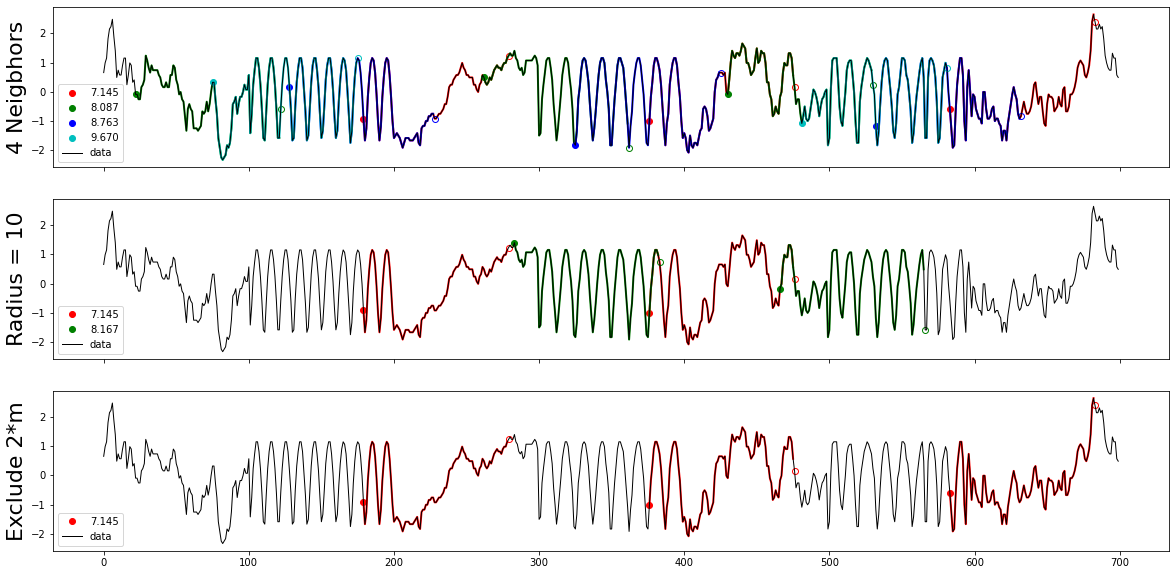

In [8]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1,sharex=True,figsize=(20,10))


mtfs ,motif_d  = motifs.motifs(pattern, mp, max_motifs=5, n_neighbors=3)
plot_motifs(mtfs, [f"{md:.3f}" for md in motif_d], ax1)
ax1.set_ylabel('4 Neigbhors', size=22)

mtfs ,motif_d  = motifs.motifs(pattern, mp, max_motifs=5, radius=1)
plot_motifs(mtfs, [f"{md:.3f}" for md in motif_d], ax2)
ax2.set_ylabel('Radius = 10', size=22)

mtfs ,motif_d  = motifs.motifs(pattern, mp, max_motifs=5, ex_zone=2*m)
plot_motifs(mtfs, [f"{md:.3f}" for md in motif_d], ax3)
ax3.set_ylabel('Exclude 2*m', size=22)
plt.savefig('motifs_neighbour.png', dpi=300, bbox_inches='tight')
plt.show()



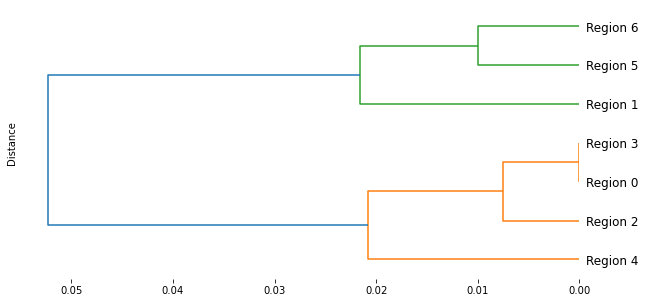

In [9]:
import numpy as np
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

# Generate a synthetic time series of length 2100
np.random.seed(0)
time_series = pattern

# Divide time series into seven equal regions
regions = np.array_split(time_series, 7)

# Create a matrix to hold the regions for clustering
region_matrix = np.array([region.mean() for region in regions]).reshape(-1, 1)

# Perform complete linkage hierarchical clustering
linked = linkage(region_matrix, method="complete")


# Plot the dendrogram to visualize the hierarchical clustering
plt.figure(figsize=(10, 5))
dendrogram(linked, labels=[f'Region {i}' for i in range(7)], orientation='left')
plt.ylabel('Distance')
plt.gca().spines["top"].set_visible(False)    # Removes top border
plt.gca().spines["right"].set_visible(False)  # Removes right border
plt.gca().spines["left"].set_visible(False)   # Removes left border
plt.gca().spines["bottom"].set_visible(False) # Removes bottom border
# plt.savefig('hier100.png', dpi=300, bbox_inches='tight')
plt.show()


# T2P Result

In [1]:
import sys
import os
from  torch.utils.data import DataLoader
import datetime
import time
sys.path.append('/home/falcon/Desktop/T2P/src/utils')

from utils.plotting_utils import Plot
from utils.plotting_utils import plot_line
from utils.color import ColorPalette
from module.model import T2P
from utils.data import TimeSeriesDataset
from train import train

import matrixprofile as mp
import numpy as np
from matplotlib import pyplot as plt
from matrixprofile.visualize import plot_snippets

from utils.plotting_utils import plot_mp_snippets
from utils.data import TimeSeriesDataset

In [2]:
# helper function to plot MP-Snippets
def plot_mp_result(figures,save_dir):
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.serif'] = ['Times New Roman', 'Times New Roman NN', 'Times', 'serif']

    SMALL_SIZE = 18
    MEDIUM_SIZE = 18
    BIGGER_SIZE = 32

    plt.rc('font', size=SMALL_SIZE)
    plt.rc('axes', titlesize=SMALL_SIZE)
    plt.rc('axes', labelsize=MEDIUM_SIZE)
    plt.rc('xtick', labelsize=SMALL_SIZE)
    plt.rc('ytick', labelsize=SMALL_SIZE)
    plt.rc('legend', fontsize=SMALL_SIZE)
    plt.rc('figure', titlesize=BIGGER_SIZE)

    # plt.style.use('seaborn-ticks')
    plt.rcParams['axes.linewidth'] = 0.75
    plt.rcParams['xtick.major.width'] = 0.75
    plt.rcParams['ytick.major.width'] = 0.75
    plt.rcParams['xtick.minor.width'] = 0.5
    plt.rcParams['ytick.minor.width'] = 0.5
    # Create a new figure with 2x2 subplots
    combined_fig, axs = plt.subplots(1, 2, figsize=(10.8, 7.2))

    # Iterate through the original figures and copy their content onto the new subplots
    for idx, (row, col) in enumerate([(0, 0), (0, 1)]):
        original_axes = figures[idx].get_axes()[0]
        new_axes = axs[row, col]

        for line in original_axes.get_lines():
            new_axes.plot(line.get_xdata(), line.get_ydata(), label=line.get_label(), color=line.get_color())

        new_axes.set_title("Snippet {}".format(idx))
        new_axes.yaxis.set_ticklabels([])
        new_axes.get_yaxis().set_visible(False)
        new_axes.xaxis.set_ticklabels([])
        new_axes.get_xaxis().set_visible(False)

    # Save the combined figure as a file
    combined_fig.savefig(save_dir+'result.png',bbox_inches="tight",transparent=True,dpi=150)
    

    # Close all figures
    for fig in figures:
        plt.close(fig)
    plt.show()
    plt.close(combined_fig)



# T2P



In [155]:
# parameters
window_size = 100
n_patterns = 2
lambda_1 = 0.94
lambda_2 = 0.13
a = 0.9
learning_rate = 1e-3
device = 'cuda'
epochs = 600

# data file path
data_name=['pattern.txt']
file_path = []
for d in data_name:
    file_path.append(os.getcwd() + f'/data/{d}')

# directory to save the result if None the result would not be saved and only depict in the notebook
runId = datetime.datetime.now().isoformat().replace(':', '_')
dn = data_name[0].split('.')[0]
save_dir = f'{os.getcwd()}/experiments/{dn}/{runId}/'
if save_dir is not None and not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [156]:
t2p = T2P(timesteps=window_size, n_patterns=n_patterns, lambda_1=lambda_1, device=device)

In [157]:
dataset = TimeSeriesDataset(file_path, window_size, device, normalization='z_norm')

In [158]:
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

In [159]:
t2p = t2p.to(device)

In [160]:
loss, sparsity = train(
                        epochs,
                        t2p,
                        dataloader,
                        learning_rate,
                        a,
                        lambda_1,
                        lambda_2,
                        device
                     )

##########Start trining##########
Epoch: 000000 | ELBO: 2.378 | Sparsity: 0.022
Epoch: 000001 | ELBO: 2.378 | Sparsity: 0.004
Epoch: 000002 | ELBO: 2.373 | Sparsity: 0.018
Epoch: 000003 | ELBO: 2.374 | Sparsity: 0.012
Epoch: 000004 | ELBO: 2.373 | Sparsity: 0.025
Epoch: 000005 | ELBO: 2.374 | Sparsity: 0.034
Epoch: 000006 | ELBO: 2.369 | Sparsity: 0.016
Epoch: 000007 | ELBO: 2.369 | Sparsity: 0.025
Epoch: 000008 | ELBO: 2.363 | Sparsity: 0.008
Epoch: 000009 | ELBO: 2.366 | Sparsity: 0.015
Epoch: 000010 | ELBO: 2.363 | Sparsity: 0.015
Epoch: 000011 | ELBO: 2.363 | Sparsity: 0.019
Epoch: 000012 | ELBO: 2.365 | Sparsity: 0.011
Epoch: 000013 | ELBO: 2.356 | Sparsity: 0.017
Epoch: 000014 | ELBO: 2.354 | Sparsity: 0.020
Epoch: 000015 | ELBO: 2.356 | Sparsity: 0.045
Epoch: 000016 | ELBO: 2.356 | Sparsity: 0.013
Epoch: 000017 | ELBO: 2.356 | Sparsity: 0.034
Epoch: 000018 | ELBO: 2.355 | Sparsity: 0.040
Epoch: 000019 | ELBO: 2.351 | Sparsity: 0.048
Epoch: 000020 | ELBO: 2.351 | Sparsity: 0.148


Epoch: 000184 | ELBO: 2.129 | Sparsity: 0.829
Epoch: 000185 | ELBO: 2.094 | Sparsity: 0.963
Epoch: 000186 | ELBO: 2.094 | Sparsity: 1.000
Epoch: 000187 | ELBO: 2.090 | Sparsity: 1.000
Epoch: 000188 | ELBO: 2.087 | Sparsity: 1.000
Epoch: 000189 | ELBO: 2.085 | Sparsity: 0.999
Epoch: 000190 | ELBO: 2.113 | Sparsity: 0.721
Epoch: 000191 | ELBO: 2.111 | Sparsity: 0.897
Epoch: 000192 | ELBO: 2.093 | Sparsity: 1.000
Epoch: 000193 | ELBO: 2.092 | Sparsity: 0.963
Epoch: 000194 | ELBO: 2.087 | Sparsity: 0.995
Epoch: 000195 | ELBO: 2.084 | Sparsity: 1.000
Epoch: 000196 | ELBO: 2.089 | Sparsity: 0.999
Epoch: 000197 | ELBO: 2.084 | Sparsity: 1.000
Epoch: 000198 | ELBO: 2.085 | Sparsity: 0.998
Epoch: 000199 | ELBO: 2.094 | Sparsity: 0.951
Epoch: 000200 | ELBO: 2.083 | Sparsity: 1.000
Epoch: 000201 | ELBO: 2.084 | Sparsity: 1.000
Epoch: 000202 | ELBO: 2.083 | Sparsity: 1.000
Epoch: 000203 | ELBO: 2.080 | Sparsity: 0.999
Epoch: 000204 | ELBO: 2.123 | Sparsity: 0.792
Epoch: 000205 | ELBO: 2.075 | Spar

Epoch: 000364 | ELBO: 2.063 | Sparsity: 0.865
Epoch: 000365 | ELBO: 2.033 | Sparsity: 0.999
Epoch: 000366 | ELBO: 2.029 | Sparsity: 1.000
Epoch: 000367 | ELBO: 2.028 | Sparsity: 0.918
Epoch: 000368 | ELBO: 2.031 | Sparsity: 1.000
Epoch: 000369 | ELBO: 2.042 | Sparsity: 0.862
Epoch: 000370 | ELBO: 2.038 | Sparsity: 0.805
Epoch: 000371 | ELBO: 2.029 | Sparsity: 0.995
Epoch: 000372 | ELBO: 2.030 | Sparsity: 1.000
Epoch: 000373 | ELBO: 2.028 | Sparsity: 1.000
Epoch: 000374 | ELBO: 2.029 | Sparsity: 1.000
Epoch: 000375 | ELBO: 2.045 | Sparsity: 0.858
Epoch: 000376 | ELBO: 2.027 | Sparsity: 1.000
Epoch: 000377 | ELBO: 2.030 | Sparsity: 0.997
Epoch: 000378 | ELBO: 2.023 | Sparsity: 0.945
Epoch: 000379 | ELBO: 2.092 | Sparsity: 0.721
Epoch: 000380 | ELBO: 2.031 | Sparsity: 0.870
Epoch: 000381 | ELBO: 2.030 | Sparsity: 0.998
Epoch: 000382 | ELBO: 2.026 | Sparsity: 0.925
Epoch: 000383 | ELBO: 2.029 | Sparsity: 0.965
Epoch: 000384 | ELBO: 2.027 | Sparsity: 1.000
Epoch: 000385 | ELBO: 2.026 | Spar

Epoch: 000549 | ELBO: 2.018 | Sparsity: 0.920
Epoch: 000550 | ELBO: 2.017 | Sparsity: 0.956
Epoch: 000551 | ELBO: 2.019 | Sparsity: 0.885
Epoch: 000552 | ELBO: 2.017 | Sparsity: 1.000
Epoch: 000553 | ELBO: 2.025 | Sparsity: 1.000
Epoch: 000554 | ELBO: 2.016 | Sparsity: 0.876
Epoch: 000555 | ELBO: 2.019 | Sparsity: 0.999
Epoch: 000556 | ELBO: 2.011 | Sparsity: 0.862
Epoch: 000557 | ELBO: 2.028 | Sparsity: 0.847
Epoch: 000558 | ELBO: 2.022 | Sparsity: 0.863
Epoch: 000559 | ELBO: 2.032 | Sparsity: 0.836
Epoch: 000560 | ELBO: 2.025 | Sparsity: 0.877
Epoch: 000561 | ELBO: 2.019 | Sparsity: 1.000
Epoch: 000562 | ELBO: 2.021 | Sparsity: 0.999
Epoch: 000563 | ELBO: 2.008 | Sparsity: 0.745
Epoch: 000564 | ELBO: 2.020 | Sparsity: 0.993
Epoch: 000565 | ELBO: 2.069 | Sparsity: 0.766
Epoch: 000566 | ELBO: 2.018 | Sparsity: 0.978
Epoch: 000567 | ELBO: 2.018 | Sparsity: 0.866
Epoch: 000568 | ELBO: 2.010 | Sparsity: 0.918
Epoch: 000569 | ELBO: 2.013 | Sparsity: 0.940
Epoch: 000570 | ELBO: 2.020 | Spar

Plot saved to /home/falcon/Desktop/T2P/src/experiments/pattern/2023-08-09T19_49_55.651781/Training Loss.png


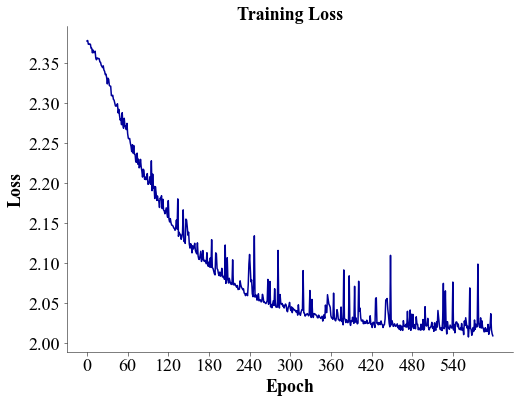

In [161]:
plot_line(loss, save_dir=save_dir)

In [162]:
t2p.train(False)
patterns = t2p.decoder.weight[:,0].data.cpu().numpy()
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
z_s = list()
alphas = list()
for i, x in enumerate(dataloader): 
    outputs = t2p(x)
    z = t2p.z.data.cpu().numpy()
    z_s.append(z[0,:,:,0,0])
    alphas.append(t2p.alpha.data.cpu().numpy()[0,:,:,0,0])

                
plot = Plot(dataset.get_input(),z_s,alphas,patterns,window_size)

Plot saved to /home/falcon/Desktop/T2P/src/experiments/pattern/2023-08-09T19_49_55.651781/patterns_analysis.png


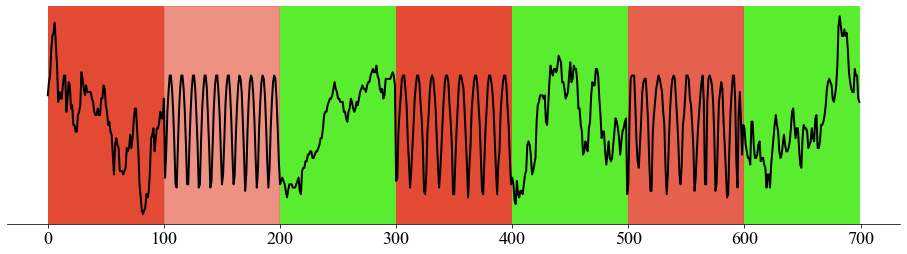

In [163]:
plot.plot_patterns_analysis(save_dir=save_dir)